2023W 136010-1 Introduction to DH Tools and Methods - Capstone Project

Student: Bernhard Ortbauer
MatrNr: 00706604

 <h1>Uppsala Conflict Data Programme (UCDP)
 <h1>UCDP  Georeferenced  Event  Dataset  (UCDP  GED)

<b>Declaration of personal interest:
I have studied history and am generally interested in the study of international conflict. I recently read Barbara F. Walter's "How Civil Wars start", which guided me to this dataset.

<b>Description of the Dataset: </b> 
GED 23.1 is a global dataset that covers the world between 1989-01-01 and 2022-12-
31. 
 
The  purpose  of  this  dataset  is  to  provide  the  academic  community  with  the  most 
comprehensive structured event data available on organised violence in the post-1989 
world, to answer the call for geographically and temporally disaggregated data.

<b>Dataset Documentation:</b>
https://ucdp.uu.se/downloads/ged/ged231.pdf

<b>Research Question:</b>
Compare Dataset for Regions and Types of conflict.
Variables interested in: - Number of conflicts - civilian deaths - deaths overall

possible findings: 
- temporal development: identification of possible cycles
- spatial development: analyze distribution within regions, maybe identify subregions

outlook:
- try to find more datasets to expand temporal perspective and include other variables, such as type of government, democratic index, etc.

<h2>Assignment 1: Exploratory Data Analysis

First I import standard libraries and the CSV data and get an overview of the data. I will decide which columns to drop. For guidance on the variable meaning, I will use the data documentation as reference.

In [82]:
import requests
from bs4 import BeautifulSoup as bs
import urllib.parse
import datetime
import re
import zipfile

import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopy.geocoders as gg
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import LineString, MultiPolygon

import folium
from folium import Choropleth, Circle, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster

from IPython.display import display, Image, HTML, IFrame, FileLink, FileLinks
from IPython.core.interactiveshell import InteractiveShell
import ipywidgets as widgets

from sklearn import preprocessing
from sklearn.cluster import KMeans

import json
#InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
#plt.switch_backend('Agg')

<b>Importing the CSV data and looking at the first rows

In [3]:
zf = zipfile.ZipFile('GEDEvent_v23_1.csv.zip') 
df = pd.read_csv(zf.open('GEDEvent_v23_1.csv'))

/tmp/ipykernel_24815/3301354906.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(zf.open('GEDEvent_v23_1.csv'))


In [4]:
df.head()

id               relid  year  active_year code_status  \
0  244657  IRQ-2017-1-524-322  2017            1       Clear   
1  412700  IRQ-2021-1-524-145  2021            1       Clear   
2  413023  IRQ-2021-1-524-143  2021            1       Clear   
3  412909  IRQ-2021-1-524-144  2021            1       Clear   
4  132140    AFG-1989-1-411-2  1989            1       Clear   

   type_of_violence  conflict_dset_id  conflict_new_id  \
0                 1               259              259   
1                 1               259              259   
2                 1               259              259   
3                 1               259              259   
4                 1               333              333   

             conflict_name  dyad_dset_id  ...                 date_end  \
0         Iraq: Government           524  ...  2017-07-31 00:00:00.000   
1         Iraq: Government           524  ...  2021-08-26 00:00:00.000   
2         Iraq: Government           524  ...  2021-08-28 00:00:00.000   
3         Iraq: Government           524  ...  2021-08-29 00:00:00.000   
4  Afghanistan: Government           724  ...  1989-01-13 00:00:00.000   

  deaths_a  deaths_b  deaths_civilians deaths_unknown  best  high  low  gwnoa  \
0        0         4                 0              2     6     6    6    645   
1       13         1               141             28   183   184  171    645   
2        0         2                 0              0     2     3    0    645   
3        0         0                10              0    10    10    9    645   
4        6         0                 0              0     6     6    6    700   

  gwnob  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  

[5 rows x 49 columns]

<b>On a global level and with all variables, the dataset seems a bit overwhelming. So I will chose a list of Variables to keep. Mainly focusing on deaths and type of violence.
Here is the list of variables from the data documentation and the decision to drop or keep the respective column

Variable name | Content | Type | Keep
---|---|---|---
id | A unique numeric ID identifying each event. | integer | Keep
relid | Only used in older versions of the dataset, empty variable in the api 23.1 version, removed in the other  ormats for UCDP GED 23.1. | '' | Drop
year | The year of the event | integer | Keep
active_year | 1: if the event belongs to an active conflict/dyad/actor-year <br>0: otherwise | integer | Drop
type_of_violence | Type of UCDP conflict: <br>1: state-based conflict <br>2: non-state conflict <br>3: one-sided violence | integer | Keep
code_status | Always clear, only used for monthly releases of candidate events, only available in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | string | Drop
conflict_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
conflict_new_id | A unique conflict identification code for each individual conflict in the dataset. | integer | Drop
conflict_name | Name of the UCDP conflict to which the event belongs. For non-state conflicts and one-sided violence this is the same as the dyad name. | string(9999) | Keep
dyad_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
dyad_new_id | A unique conflict identification code for each individual dyad in the dataset. | integer | Drop
dyad_name | Name of the conflict dyad creating the event. A dyad is the pair of two actors engaged in violence (in the case of one-sided violence, the perpetrator of violence and civilians). | string(9999) | Keep
side_a_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
side_a_new_id | A unique ID of side A. | integer | Drop
side_a | The name of Side A in the dyad. In state-based conflicts always a government. In one-sided violence always the perpetrating party. | string(9999) | Keep
side_b_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
side_b_new_id | A unique ID of side B. | integer | Drop
side_b | The name of Side B in the dyad. In state-based always the rebel movement or rivalling government. In one-sided violence always “civilians”. | string(9999) | Keep
number_of_sources | Number of total sources containing information for an event that were consulted. | integer | Drop
source_article | References to the names, dates and titles of the source material from which information on the event is gathered. | text | Drop
source_office | The name of the organizations publishing the source materials. | text | Drop
source_date | The dates the source materials were published on. | text | Drop
source_headline | The titles of the source materials. | text | Drop
source_original | The name or type of person or organization from which the information about the event originates in the original report. e.g. “police”, “Lt. Col. Johnson”, ”eyewitnesses”, “rebel spokesman”. | string(9999) | Drop
where_prec | The precision with which the coordinates and location assigned to the event reflects the location of the actual event. <br>1: exact location of the event known and coded. <br>2: event occurred within at maximum a ca. 25 km radius around a known point. The coded point is the known point. <br>3: only the second order administrative division where an event happened is known. That administrative division is coded with a point representing it (typically the centroid). <br>4: only the first order administrative division where an event happened is known. That administrative division is coded with a point representing it <b>(typically the centroid)</b>. <br>5: the only spatial reference for the event is neither a known point nor a known formal administrative division, but rather a linear feature (e.g. a long river, a border, a longer road or the line connecting two locations further afield than 25 km) or a fuzzy polygon without defined borders (informal regions, large radiuses etc.). A representation point is chosen for the feature and employed. <br>6: only the country where the event took place in is known. <br>7: event in international waters or airspace. | integer | Drop
where_coordinates | Name of the location to which the event is assigned. Fully standardized and normalized. | string(9999) | Keep
where_description | Comment on the location coded, sometimes left empty can include area of the capital or name of a village that has not been found | string | Keep
adm_1 | Name of the first order (largest) administrative division where the event took place | string(9999) | Keep
adm_2 | Name of the second order administrative division where the event took place |string(9999) | Keep
latitude | Latitude (in decimal degrees) | numeric(9,6) | Keep
longitude | Longitude (in decimal degrees) | numeric(9,6) | Keep
geom_wkt | An Open Geospatial Consortium textual representation of the location of each individual point. Formatted as OGC WKT (well known text) without SRID. | string(9999) | Keep
priogrid_gid | The PRIO-grid cell id (gid) in which the event took place. | integer | Drop
country | Name of the country in which the event takes place. | string(999) | Keep
country_id | Gleditsch and Ward number of the country in which the event takes place. | integer | Drop
region | Region where the event took place. One of following: {Africa, Americas, Asia, Europe, Middle East} | string(999) | Keep
event_clarity | 1 (high) for events where the reporting allows the coder to identify the event in full. <br>2 (lower) for events where an aggregation of information was already made by the source material that is impossible to undo in the coding process. Such events are described by the original source only as aggregates (totals) of multiple separate activities of fighting spanning over a longer period than a single, clearly defined day. | integer | Drop
date_prec | How precise the information is about the date of an event. <br>1: exact date of event is known; <br>2: the date of the event is known only within a 2-6 day range. <br>3: only the week of the event is known <br>4: the date of the event is known only within an 8-30 day range or only the month when the event has taken place is known <br>5: the date of the event is known only within a range longer than one month but not more than one calendar year. | integer | Drop
date_start | The earliest possible date when the event has taken place. | Date YYYY-MM-DD | Keep
date_end | The last possible date when the event has taken place. | Date YYYY-MM-DD | Keep
deaths_a | The best estimate of deaths sustained by side a. Always 0 for one-sided violence events. | integer | Keep
deaths_b | The best estimate of deaths sustained by side b. Always 0 for one-sided violence events. | integer | Keep
deaths_civilians | The best estimate of dead civilians in the event. | integer | Keep
deaths_unknown | The best estimate of deaths of persons of unknown status. | integer | Drop
best | The best (most likely) estimate of total fatalities resulting from an event. It is always the sum of deaths_a, deaths_b, deaths_civilians and deaths_unknown. | integer | Keep
high | The highest reliable estimate of total fatalities | integer | Drop
low | The lowest reliable estimate of total fatalities | integer | Drop
gwnoa | The Gleditsch and Ward number for Side A if the side is a state. Empty if Side A is not a state. | string(9999) | Drop
gwnob | The Gleditsch and Ward number for Side B if the side is a state. Empty if Side B is not a state. | string(9999) | Drop




<b>Initial manipulations:
- select columns
- change type to datetime

In [9]:
select_columns = ['id', 'year', 'type_of_violence', 'conflict_name', 'dyad_name', 'side_a', 'side_b',
                  'where_coordinates', 'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude', 'geom_wkt', 'country', 'region',
                  'date_start', 'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians', 'best']

df_conflict = df[select_columns]
df_conflict = df_conflict.sort_values(['year', 'region', 'country'])

In [10]:
df_conflict.head()
df_conflict['date_start'] = pd.to_datetime(df_conflict['date_start'])
df_conflict['date_end'] = pd.to_datetime(df_conflict['date_end'])
#df_conflict.info()



<b>at first I want to look at Europe to get a feeling for the data on a bit smaller scale

In [11]:
eu_conflict = df_conflict[df_conflict.region == 'Europe']
eu_conflict = eu_conflict.reset_index(drop=True)
#eu_conflict.head()
#eu_conflict.info()

In [8]:

def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

#unique_col_values(eu_conflict)

<b>Austria is present with one entry: the terror attack of Vienna in 2020

In [10]:
eu_conflict[eu_conflict.country == 'Austria']

id  year  type_of_violence   conflict_name       dyad_name side_a  \
18660  364836  2020                 3  IS - Civilians  IS - Civilians     IS   

          side_b where_coordinates where_description              adm_1  ...  \
18660  Civilians       Vienna city   Vienna, Austria  Vienna bundesland  ...   

       longitude                     geom_wkt  country  region date_start  \
18660  16.373724  POINT (16.373724 48.208285)  Austria  Europe 2020-11-02   

        date_end deaths_a deaths_b  deaths_civilians  best  
18660 2020-11-02        0        0                 4     4  

[1 rows x 22 columns]

<h3>Yearly overview on region level</h3>

<b>first i want to get a feeling for the data on a regional level. I start by analyzing over the years.

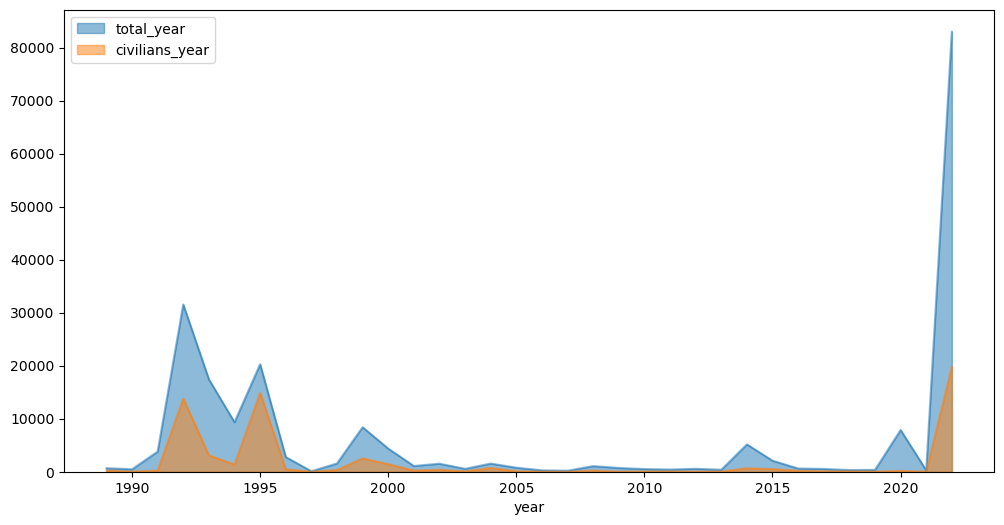

In [13]:
dths_yr = eu_conflict.groupby('year')["best"].sum().rename("total_year").reset_index()
civs_yr = eu_conflict.groupby('year')["deaths_civilians"].sum().rename("civilians_year").reset_index()
dths_yr = dths_yr.merge(civs_yr)
dths_yr.plot(x='year', kind='area', stacked=False);

<b>What we can see, is the total number of deaths escalated in the recent years (presumably Ukraine). There is a huge difference over the years in the number of fatalities and the proportion of civilians. Also interesting is the type of violence as mentioned initially.

In [15]:
deaths_per_year = eu_conflict.pivot_table('best', index='year', columns='type_of_violence', aggfunc=sum).rename(columns={1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'})
#deaths_per_year.head(10)
#deaths_per_year.tail()
#deaths_per_year.plot(title='Total deaths by conflict type and year');

/tmp/ipykernel_24815/924565722.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  deaths_per_year = eu_conflict.pivot_table('best', index='year', columns='type_of_violence', aggfunc=sum).rename(columns={1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'})


<b>What we see from the above plot, is that state-based conflicts account for the most deaths, that comes as no suprise, as those are fought with full size armies. Interested if the picture is the same when we focuse on number of events.

In [17]:
events_per_year = eu_conflict.pivot_table('best', index='year', columns='type_of_violence', aggfunc='count').rename(columns={1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'})
#events_per_year.head(10)
#deaths_per_year.tail()
#events_per_year.plot(title='Single Violence Events by conflict type and year');

<b>The numbers go also way up after 2020, but the difference to the early 90ies is not so extreme. Which indicates that todays events have more fatalities per event in average. We also see that there are throughoutonly some one-sided violence events, but compared to non state conflict, they have much higher fatality numbers. Let's see if this shows in another plot:

In [18]:
deaths_per_event_year = deaths_per_year / events_per_year
#deaths_per_event_year.head(10)
#deaths_per_year.tail()


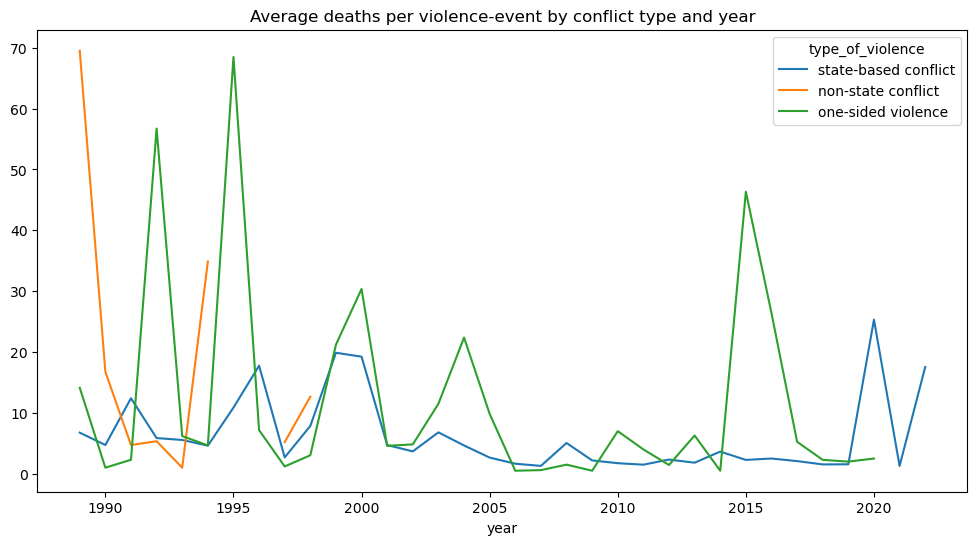

In [15]:
deaths_per_event_year.plot(title='Average deaths per violence-event by conflict type and year');

<b>This is impressive: one-sided violence seems especially prone to killing a lot of people - including genocidal events. The 1989 saw a low number of deaths and events overall, but the overall number was mainly driven by non-state conflict. This type of violence disappeared from Europe with the end of the 90ies.

Now it would be interesting, how the number of deaths per event is distributed among all events.

In [20]:
#eu_conflict.hist('best', bins = 20)
#plt.xlim((5, 11))
#plt.ylim((0, 12))
#plt.title("Histogram Total Fatalities per event")
#plt.grid(False)

<b>The histogram of deaths per event shows only one bar and that at the lowest end. There are nearly 25000 violence-events with no or very few fatalities. But the x-scale goes up to 8000 fatalities. This relativates all above findings, as it seems, that the big numbers are mainly driven by a very small sample of especially deadly events. This also makes the dataset very hard to compare on a event basis. When we exclude the big bulk of smaller events with less than 200 fatalities, the picture clears up a bit. Still we have the great majority at the lower end. We see, however, that the scale even extends to 16000 fatalities in one single event (see below).

In [21]:
# eu_conflict[eu_conflict.best >200].hist('best', bins = 20)
# #plt.xlim((5, 11))
# #plt.ylim((0, 12))
# plt.title("Histogram Total Fatalities >200 per event")
# plt.grid(False)

<b>Of course also the boxplot makes not a lot of sense:

In [22]:
# plt.figure(figsize=(13,9))
# sns.boxplot(data = eu_conflict,
#             y = 'best',
#             color = 'cadetblue',
#             width = 0.2,
#             linewidth = 3,
#             medianprops={'color':'white'});

<b>unless we log-scale y, but we got the picture anyway. Statistically speaking, when looking at all events, we see that all events with more than 5 or 6 fatalities are outliers. I would be interested if that holds true on the worldwide level.

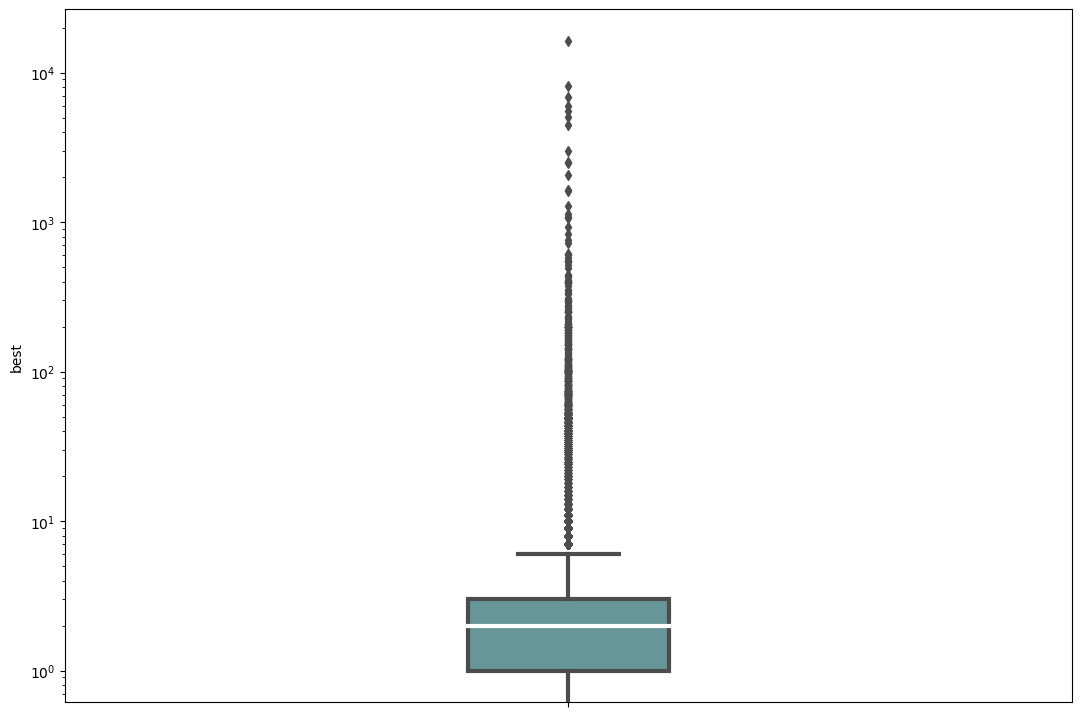

In [19]:
plt.figure(figsize=(13,9))
bx = sns.boxplot(data = eu_conflict,
            y = 'best',
            color = 'cadetblue',
            width = 0.2,
            linewidth = 3,
            medianprops={'color':'white'})
bx.set_yscale('log')

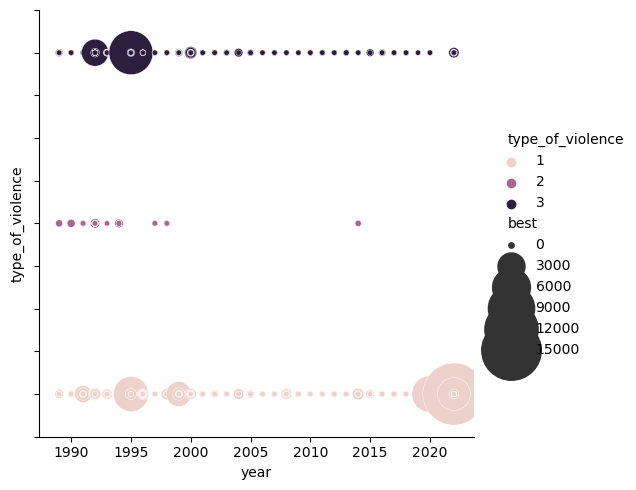

In [20]:
ax = sns.relplot(
    data=eu_conflict, x="year", y="type_of_violence",
    size="best", sizes=(15, 2000),
    hue='type_of_violence'
)
ax.set_yticklabels('')
ax.tight_layout();


<b>The plot above is more informative: state-based conflicts (1) make up for the biggest single events, the biggest after 2020. Non-state violence events (2) happen on a smaller scale, while there were very brutal one-sided events in the first half of the 90ies. The biggest in 1995.

In [23]:
# select_columns = ['type_of_violence','best','deaths_civilians',
#                    'country', 'year']

# sns.pairplot(eu_conflict[select_columns], hue='type_of_violence', height=3, diag_kws={'bw_method': 0.2});

<h3>Geographical distribution</h3>
<b>Now I will try to add the aerial dimension to the temporal analysis, I have done so far. Therefore I will furthre reduce the dataset.

In [24]:
select_columns = ['year', 'type_of_violence', 'where_description', 'latitude', 'longitude', 'country',
                  'deaths_civilians', 'best']

eu_conf_reduced = eu_conflict[select_columns]
#eu_conf_reduced

<b>I want to create a map, where i can show a heatmap weighted with the deaths in a location. Therefore I will normalise the total number of deaths per event on the total number of deaths in the respective year.

In [25]:

dths_yr = eu_conf_reduced.groupby('year')["best"].sum().rename("best_year").reset_index()
civs_yr = eu_conf_reduced.groupby('year')["deaths_civilians"].sum().rename("civilians_year").reset_index()
eu_conf_reduced = eu_conf_reduced.merge(dths_yr)
eu_conf_reduced = eu_conf_reduced.merge(civs_yr)
eu_conf_reduced['best_weight'] = eu_conf_reduced['best'] / eu_conf_reduced['best_year']
eu_conf_reduced['civ_weight'] = eu_conf_reduced['deaths_civilians'] / eu_conf_reduced['civilians_year'] 
eu_conf_reduced = eu_conf_reduced.drop(columns=['deaths_civilians', 'best', 'best_year', 'civilians_year'])

    

<b>a heatmap with time needs a list of weighted coordinates. Therefore i group the weights per year by both lat and lon and store the results in lists.

In [27]:
data = []

for yr in eu_conf_reduced['year'].sort_values().unique():
    data.append(eu_conf_reduced.loc[eu_conf_reduced['year'] == yr,
                                    ['latitude', 'longitude', 'best_weight']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
#data

<b>I chose a dark background map to better see the heatmap

In [28]:
index = eu_conf_reduced['year'].sort_values().unique().tolist()
tiles = 'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png'
attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
m = folium.Map([48.0, 5.0], zoom_start=4, tiles=tiles, attr=attr, max_zoom=4, min_zoom=4)

hm = folium.plugins.HeatMapWithTime(data, index=index, auto_play=False)

hm.add_to(m)

m

<b>Looking at the series we can see that deadly events mostly disappeared from Western Europe with the 90ies. The balkan is a hotspot until 2001 and disappears afterwards. The caucasus region is in almost constant conflict. In 2022 we can clearly see the Ukrainian border areas as the main areas, leaving no room for other "heat" anywhere else on the map.

<h3>Analysis on a single event basis</h3>
<b>I will continue exploring on a much smaller scale and look at a single event. I am interested in the single event withe the most civilian deaths.

In [29]:
civil_worst = eu_conflict[eu_conflict.deaths_civilians == eu_conflict['deaths_civilians'].max()]
civil_worst

id  year  type_of_violence  \
11088  199704  1995                 3   

                                           conflict_name  \
11088  Serbian irregulars, Serbian Republic of Bosnia...   

                                               dyad_name  \
11088  Serbian irregulars, Serbian Republic of Bosnia...   

                                                  side_a     side_b  \
11088  Serbian irregulars, Serbian Republic of Bosnia...  Civilians   

      where_coordinates where_description adm_1  ...  longitude  \
11088   Srebrenica town   Srebrenica town   NaN  ...  19.296944   

                          geom_wkt             country  region date_start  \
11088  POINT (19.296944 44.106389)  Bosnia-Herzegovina  Europe 1995-07-10   

        date_end deaths_a deaths_b  deaths_civilians  best  
11088 1995-07-11        0        0              8106  8106  

[1 rows x 22 columns]

<b>As I have expected it is the genocidal event in Srebrenica in 1995. Let's map it out.

In [37]:
geolocator = gg.Nominatim(user_agent="test_application") #https://operations.osmfoundation.org/policies/nominatim/

In [38]:
address = civil_worst.where_description.values[0]
location = geolocator.geocode(address)
print(location.address)
print(location.longitude)
print(location.latitude)
print(civil_worst.where_coordinates.values[0])
print(civil_worst.longitude.values[0])
print(civil_worst.latitude.values[0])
print(civil_worst.geom_wkt.values[0])
print(civil_worst.date_start.values[0])
print(civil_worst.date_end.values[0])

Srebrenica, Opština Srebrenica, Република Српска / Republika Srpska, 75430, Bosna i Hercegovina / Босна и Херцеговина
19.2952783
44.1063188
Srebrenica town
19.296944
44.106389
POINT (19.296944 44.106389)
1995-07-10T00:00:00.000000000
1995-07-11T00:00:00.000000000


<b>We see that all stored positional information refers to the same coordinates so we can use any of them.

<b>I want a vector shape of Bosnia to overlay my map with. Therefore I import a geojson file with all countries. This might come handy later on and try to isolate Bosnia.

In [44]:
# gdf = gpd.read_file('countries.geojson').set_index('ADMIN')
#gdf

In [33]:

#gdf.plot()

In [34]:
# bosnia = gdf[gdf.index == 'Bosnia and Herzegovina']
#bosnia.plot()

<b>Now lets pin down Srebrenica on a map.

In [39]:
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
srebrenica = folium.Map([location.latitude, location.longitude], zoom_start=15, tiles=tiles, attr=attr)
info = f"{address}\nDate: {civil_worst.date_start.values[0]} \nDead Civilians: {civil_worst.deaths_civilians.values[0]}"
tooltip = "Click me!"
folium.Marker([location.latitude, location.longitude], popup=info, tooltip=tooltip, icon=folium.Icon(color="red", icon="info-sign")).add_to(srebrenica)
srebrenica

<b>When we underly an aerial photograph, we see that the coordinates point to the town center, but not to the place of the massacre itself. I will add this here manually, but this will not be feasible for the whole dataset. On a single event basis we could measure the geolocation accuracy.

In [40]:
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
srebrenica = folium.Map([location.latitude, location.longitude], zoom_start=12, tiles=tiles, attr=attr)
info = f"{address}\nDate: {civil_worst.date_start.values[0]} \nDead Civilians: {civil_worst.deaths_civilians.values[0]}"
folium.Marker([location.latitude, location.longitude], popup=info, icon=folium.Icon(color="red", icon="info-sign")).add_to(srebrenica)
folium.Marker([44.15622017651065, 19.303108942357685], popup='location of massacre', icon=folium.Icon(color="black", icon="info-sign")).add_to(srebrenica)
srebrenica

<b>To make use of the vector layer, let's move the map to a bigger scale:

In [41]:
#url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")

#antarctic_ice_edge = f"{url}/antarctic_ice_edge.json"
#antarctic_ice_shelf_topo = f"{url}/antarctic_ice_shelf_topo.json"


# tiles = 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png'
# attr = 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)'
# m = folium.Map([location.latitude, location.longitude], zoom_start=8, tiles=tiles, attr=attr)
# info = f"{address}\nDate: {civil_worst.date_start.values[0]} \nDead Civilians: {civil_worst.deaths_civilians.values[0]}"
# #tooltip = "Click me!"
# folium.Marker([location.latitude, location.longitude], popup=info, tooltip=tooltip, icon=folium.Icon(color="red", icon="info-sign")).add_to(m)
# folium.GeoJson(bosnia, name="geojson", color='blue').add_to(m)
# #folium.TopoJson(json.loads(requests.get(antarctic_ice_shelf_topo).text), "objects.antarctic_ice_shelf", name="topojson",).add_to(m)
# folium.LayerControl().add_to(m)
#m

<h3>Analysis on a conflict basis</h3>
<b>Next I will move the focus of the analysis to a single conflict. Most probably I will choose the end of the Troubles in Northern Ireland. But let's first see, which countries are most affected in terms of civilian loss...

In [42]:
deaths_per_year = eu_conflict.pivot_table('deaths_civilians', index='country', columns='year', aggfunc=sum)
#deaths_per_year


/tmp/ipykernel_24815/3653180513.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  deaths_per_year = eu_conflict.pivot_table('deaths_civilians', index='country', columns='year', aggfunc=sum)


<b>Northern Ireland falls under the United Kingdom. Interesting enough that in the recorded period no civil fatalities were recorded in Ireland. It also makes me shivering how much Bosnia has suffered proportionately. This calls for another plot, maybe a pie chart?:

<Axes: xlabel='country'>

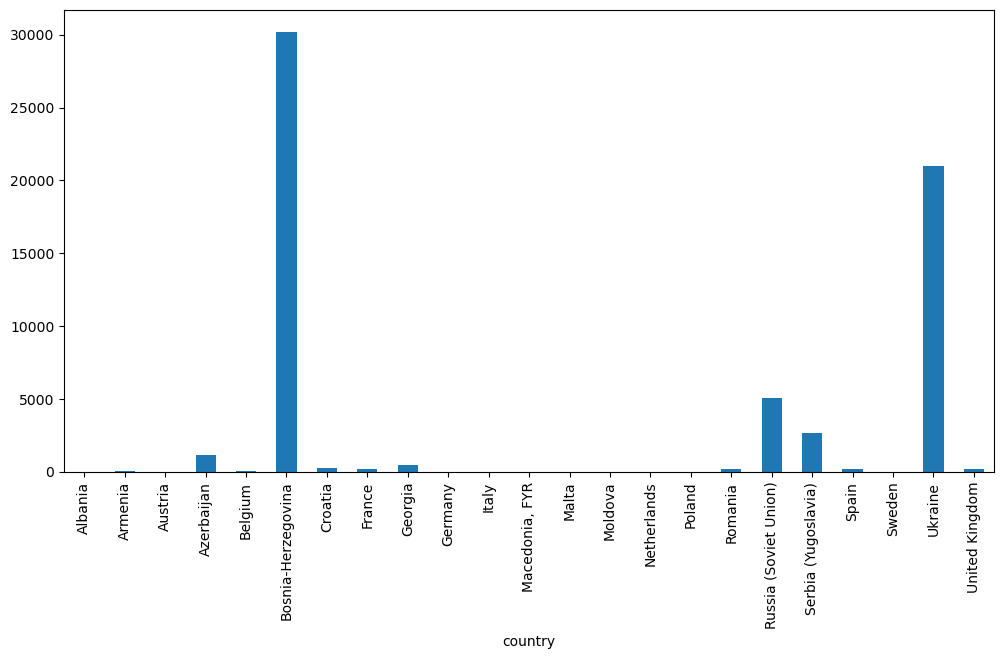

In [43]:
civ_per_country = deaths_per_year.sum(axis=1)
civ_per_country.plot(kind='bar')

<b>Unbelievable.<br>
Now I move on to Northern Ireland and the IRA

<h3>The Northern Ireland Conflict (1989 to 2000) - The local/national level

In [62]:
brit_events = eu_conflict[eu_conflict.country == 'United Kingdom']
#brit_events

In [63]:
brit_conflicts = brit_events["conflict_name"].unique()
trouble_conflicts = [brit_conflicts[0], brit_conflicts[1]]
trouble_events = brit_events[brit_events.conflict_name.isin(trouble_conflicts)]
#trouble_events

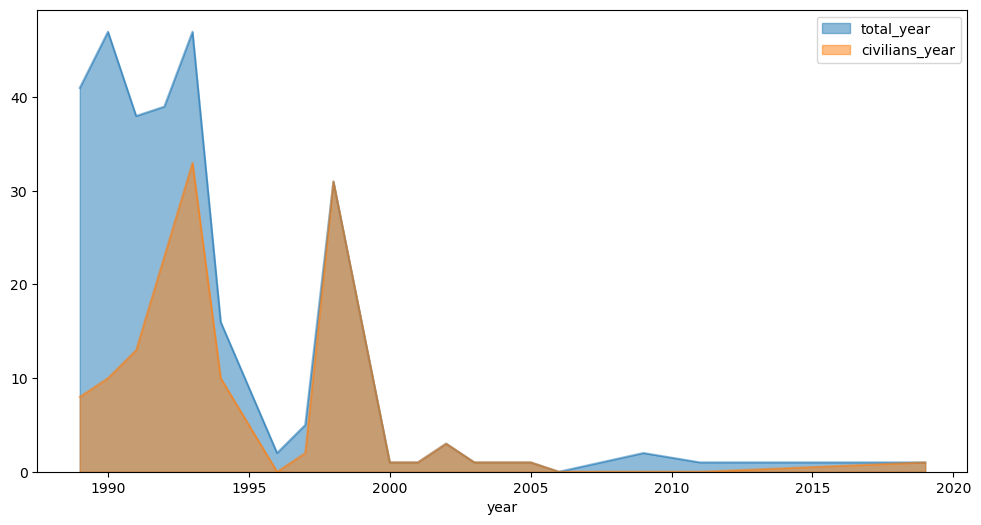

In [64]:
ie_dths_yr = trouble_events.groupby('year')["best"].sum().rename("total_year").reset_index()
ie_civs_yr = trouble_events.groupby('year')["deaths_civilians"].sum().rename("civilians_year").reset_index()
ie_dths_yr = ie_dths_yr.merge(ie_civs_yr)
ie_dths_yr.plot(x='year', kind='area', stacked=False);

In [65]:
# ie_deaths_per_year = trouble_events.pivot_table('best', index='year', columns='type_of_violence', aggfunc=sum).rename(columns={1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'})
# ie_deaths_per_year.head(10)
# #deaths_per_year.tail()
# ie_deaths_per_year.plot(title='Total deaths by conflict type and year');

In [66]:
# ie_events_per_year = trouble_events.pivot_table('best', index='year', columns='type_of_violence', aggfunc='count').rename(columns={1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'})
# ie_events_per_year.head(10)
# #deaths_per_year.tail()
# ie_events_per_year.plot(title='Single Violence Events by conflict type and year');

In [67]:
# ie_deaths_per_event_year = ie_deaths_per_year / ie_events_per_year
# ie_deaths_per_event_year.head(10)
#deaths_per_year.tail()

In [68]:
#ie_deaths_per_event_year.plot(title='Average deaths per violence-event by conflict type and year');

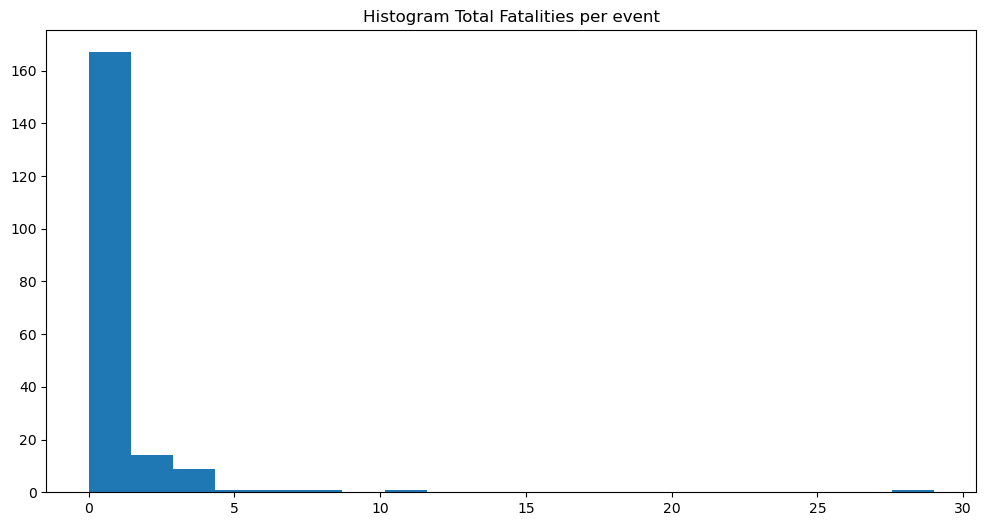

In [69]:
trouble_events.hist('best', bins = 20)
#plt.xlim((5, 11))
#plt.ylim((0, 12))
plt.title("Histogram Total Fatalities per event")
plt.grid(False)

/home/bernhard/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


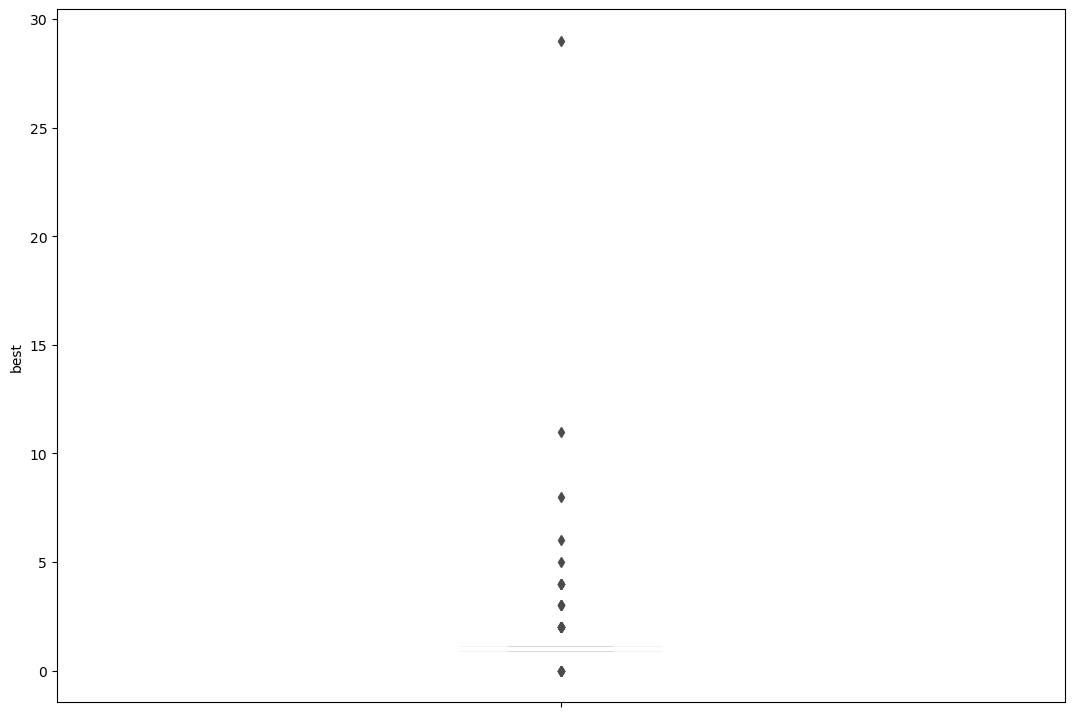

In [70]:
plt.figure(figsize=(13,9))
sns.boxplot(data = trouble_events,
            y = 'best',
            color = 'cadetblue',
            width = 0.2,
            linewidth = 3,
            medianprops={'color':'white'});

In [71]:
# plt.figure(figsize=(13,9))
# bx = sns.boxplot(data = trouble_events,
#             y = 'best',
#             color = 'cadetblue',
#             width = 0.2,
#             linewidth = 3,
#             medianprops={'color':'white'})
# bx.set_yscale('log')

In [72]:
# ax = sns.relplot(
#     data=trouble_events, x="year", y="type_of_violence",
#     size="best", sizes=(15, 2000),
#     hue='type_of_violence'
# )
# ax.set_yticklabels('')
# ax.tight_layout();

In [73]:
# ax = sns.relplot(
#     data=trouble_events, x="year", y="where_description",
#     size="best", sizes=(15, 2000),
#     hue='type_of_violence'
# )
# ax.set_yticklabels('')
# ax.tight_layout();

In [78]:
select_columns = ['year', 'type_of_violence', 'where_description', 'latitude', 'longitude', 'country',
                  'deaths_civilians', 'best']

trouble_events_red = trouble_events[select_columns]
#trouble_events_red

In [77]:

# dths = trouble_events_red["best"].sum()
# civs = trouble_events_red["deaths_civilians"]
# # trouble_events_red = trouble_events_red.merge(dths_yr)
# # trouble_events_red = trouble_events_red.merge(civs_yr)
# trouble_events_red['best_weight'] = trouble_events_red['best'] / dths
# trouble_events_red['civ_weight'] = trouble_events_red['deaths_civilians'] / civs
# trouble_events_red = trouble_events_red.drop(columns=['deaths_civilians', 'best'])

    

In [79]:

dths_yr = trouble_events_red.groupby('year')["best"].sum().rename("best_year").reset_index()
civs_yr = trouble_events_red.groupby('year')["deaths_civilians"].sum().rename("civilians_year").reset_index()
trouble_events_red = trouble_events_red.merge(dths_yr)
trouble_events_red = trouble_events_red.merge(civs_yr)
trouble_events_red['best_weight'] = trouble_events_red['best'] / trouble_events_red['best_year']
trouble_events_red['civ_weight'] = trouble_events_red['deaths_civilians'] / trouble_events_red['civilians_year'] 
trouble_events_red = trouble_events_red.drop(columns=['deaths_civilians', 'best', 'best_year', 'civilians_year'])

    

In [80]:
data = []

for yr in trouble_events_red['year'].sort_values().unique():
    data.append(trouble_events_red.loc[trouble_events_red['year'] == yr,
                                    ['latitude', 'longitude', 'best_weight']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
#data

In [81]:
index = trouble_events_red['year'].sort_values().unique().tolist()
tiles = 'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png'
attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
m = folium.Map([54.6, -6.4], zoom_start=9, tiles=tiles, attr=attr, max_zoom=9, min_zoom=9)

hm = folium.plugins.HeatMapWithTime(data, index=index, auto_play=False)

hm.add_to(m)

m

In [86]:
trouble_events = trouble_events[trouble_events.year<2002]
trouble_cities = trouble_events["where_description"].unique()
trouble_cities.sort()
trouble_cities

array(['Armagh town', 'Ballycastle town', 'Ballymoney town',
       'Belcoo village', 'Belfast Town (Ardoyne area)',
       'Belfast Town (New Lodge area of North Belfast)', 'Belfast town',
       'Bellaghy village', 'Belleek village', 'Bessbrook village',
       'Brookeborough village', 'Cappagh village', 'Castlederg village',
       'Castlerock village',
       'Castor Bay, near Morrows Point, Lough Neagh,', 'Coagh village',
       'Coalisland town', 'Comber town .', 'Cookstown town',
       'Crossgar village', 'Crossmaglen village', 'Cullyhanna village',
       'Deal town', 'Derry town', 'Donaghcloney village',
       'Donaghmore village (near Caste Caulfield)', 'Downpatrick town',
       'Drumquin village', 'Dungannon town', 'Fivemiletown village',
       'Forkhill village', 'Garvagh village', 'Glenanne village',
       'Greysteel village', 'Hamiltonsbawn village',
       'Jonesborough village', 'Keady village', 'Kilrea town',
       'Lichfield town', 'Lisbellaw  village', 'Lisburn

In [87]:
armagh_events = trouble_events[trouble_events['where_description'] == 'Armagh town']
armagh_events

id  year  type_of_violence                     conflict_name  \
104    66300  1990                 1  United Kingdom: Northern Ireland   
108    66324  1990                 1  United Kingdom: Northern Ireland   
8201   67358  1993                 1  United Kingdom: Northern Ireland   
10199  66530  1994                 1  United Kingdom: Northern Ireland   

                                 dyad_name                        side_a  \
104    Government of United Kingdom - PIRA  Government of United Kingdom   
108    Government of United Kingdom - PIRA  Government of United Kingdom   
8201   Government of United Kingdom - PIRA  Government of United Kingdom   
10199  Government of United Kingdom - PIRA  Government of United Kingdom   

      side_b where_coordinates where_description             adm_1  ...  \
104     PIRA       Armagh town       Armagh town  Northern Ireland  ...   
108     PIRA       Armagh town       Armagh town  Northern Ireland  ...   
8201    PIRA       Armagh town       Armagh town  Northern Ireland  ...   
10199   PIRA       Armagh town       Armagh town  Northern Ireland  ...   

      longitude                geom_wkt         country  region date_start  \
104    -6.66667  POINT (-6.66667 54.35)  United Kingdom  Europe 1990-01-22   
108    -6.66667  POINT (-6.66667 54.35)  United Kingdom  Europe 1990-03-28   
8201   -6.66667  POINT (-6.66667 54.35)  United Kingdom  Europe 1993-02-09   
10199  -6.66667  POINT (-6.66667 54.35)  United Kingdom  Europe 1994-05-21   

        date_end deaths_a deaths_b  deaths_civilians  best  
104   1990-01-22        1        0                 0     1  
108   1990-03-28        1        0                 0     1  
8201  1993-02-09        1        0                 0     1  
10199 1994-05-21        1        0                 0     1  

[4 rows x 22 columns]

In [102]:
index = "https://cain.ulster.ac.uk/sutton/chron/index.html"
url_parse_results = urllib.parse.urlparse(index)
url_parse_results
base = "://".join([url_parse_results.scheme, url_parse_results.netloc])
r = requests.get(index)
soup = bs(r.content) 

def get_victim_info(datum):
  
    info_dict = {}
    
    year =  datum.year
    month = datum.month
    day = datum.day

    date = datetime.date(year, month, day)
    str_date = date.strftime("%d %B %Y")

    link = soup.find_all('a', href=True, string = year)
    if len(link) > 1:
        raise ReferenceError

    targetURL = "".join([base, link[0]["href"]])
    req = requests.get(targetURL)
    db_soup = bs(req.content)

    ppl = db_soup.find_all(True, string = re.compile(str_date))

    #persons ={}

    for p in ppl:
        d = [text for text in p.parent.stripped_strings]
        im = "".join([base, p.parent.previous_sibling.contents[0]["src"]])


        name = d[1]
        age = d[2].split(")")[0][1:]
        religion = d[2].split(")")[-1].strip()
        status = d[4].strip()[:-1]
        killer = d[6].strip()
        location = d[7].strip()

        info_dict = {
                "name": name,
                "age": age,
                "religion": religion,
                "status": status,
                "killed_by": killer,
                "location": location,
                "image": im
        }
        #persons.update({id: info_dict})

        return(json.dumps(info_dict))


In [115]:
amargh_deaths = {}

for ind in armagh_events.index:
    date_start = armagh_events["date_start"][ind]
    id = int(armagh_events["id"][ind])
    
    victims = get_victim_info(date_start)
    print(victims)
    if id in amargh_deaths:
        amargh_deaths[str(id)].append(victims)
    else:
        amargh_deaths[str(id)] = [victims]


{"name": "Monteith, Derek", "age": "35", "religion": "Protestant", "status": "Royal Ulster Constabulary (RUC)", "killed_by": "Irish Republican Army (IRA)", "location": "Off duty. Shot at his home, Kilburn Park, Armagh.", "image": "https://cain.ulster.ac.uk/victims/humanface/photos/Monteith_Derek_220190.jpg"}
{"name": "Starrett, George", "age": "58", "religion": "Protestant", "status": "Royal Ulster Constabulary (RUC)", "killed_by": "Irish Republican Army (IRA)", "location": "Off duty. Shot at his home, Newry Road, Armagh.", "image": "https://cain.ulster.ac.uk/victims/humanface/photos/Starrett_George_280390.jpg"}
{"name": "Beswick, Michael", "age": "21", "religion": "nfNI", "status": "British Army (BA)", "killed_by": "Irish Republican Army (IRA)", "location": "Killed by remote controlled bomb hidden in wall, detonated when British Army (BA) foot patrol passed, Cathedral Road, Armagh.", "image": "https://cain.ulster.ac.uk/victims/humanface/photos/Beswick_Michael_090293.jpg"}
{"name": "Mc

In [119]:
with open("amargh_deaths.json", "w", encoding='utf-8') as file:
    json.dump(amargh_deaths, file, ensure_ascii=False, indent=4)
type(amargh_deaths)

dict

In [134]:
address = armagh_events.where_description.values[0]
location = geolocator.geocode(address)
location

long = armagh_events.longitude.values[0]
lat = armagh_events.latitude.values[0]
print(long, lat)

-6.66667 54.35


In [129]:
with open("amargh_deaths.json", "r") as fil:
    testPages = json.load(fil)

loc_test = geolocator.geocode(json.loads(testPages["66300"][0])["location"])
print(loc_test)



None


In [137]:
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
amargh = folium.Map([lat, long], zoom_start=15, tiles=tiles, attr=attr)
info = amargh_deaths,
folium.Marker([lat, long], popup=info, icon=folium.Icon(color="red", icon="info-sign")).add_to(amargh)
amargh

<h2>Global Analysis

In [38]:
select_columns = ['year', 'type_of_violence', 'where_description', 'latitude', 'longitude', 'country',
                  'deaths_civilians', 'best']

int_conf_reduced = df_conflict[select_columns]
int_conf_reduced

year  type_of_violence                   where_description   latitude  \
46025   1989                 1                              Angola -12.500000   
46026   1989                 1                  Belize town (near)  -4.650000   
46027   1989                 1            Lukapa (in the vicinity)  -9.650000   
46028   1989                 1                        Cambulo town  -7.750000   
46029   1989                 1  Lukapa town (near) (Chiumbe river)  -8.416667   
...      ...               ...                                 ...        ...   
316707  2022                 2                           Ataq city  14.537665   
316708  2022                 2                           Ataq city  14.537665   
316709  2022                 2         airport in the city of Ataq  14.550278   
316710  2022                 2            vicinity of Ataq airport  14.550278   
316711  2022                 2                Iyadh area in Jardan  14.993940   

        longitude              country  deaths_civilians  best  
46025   18.500000               Angola                 0     1  
46026   12.766667               Angola                 0     0  
46027   20.400000               Angola                 0     0  
46028   21.250000               Angola                 0     0  
46029   20.750000               Angola                 0     0  
...           ...                  ...               ...   ...  
316707  46.831868  Yemen (North Yemen)                 1     3  
316708  46.831868  Yemen (North Yemen)                 5     5  
316709  46.825000  Yemen (North Yemen)                 0    29  
316710  46.825000  Yemen (North Yemen)                 1     1  
316711  46.843190  Yemen (North Yemen)                 1     1  

[316818 rows x 8 columns]

In [39]:
int_dths_yr = int_conf_reduced.groupby('year')["best"].sum().rename("best_year").reset_index()
int_civs_yr = int_conf_reduced.groupby('year')["deaths_civilians"].sum().rename("civilians_year").reset_index()
int_conf_reduced = int_conf_reduced.merge(int_dths_yr)
int_conf_reduced = int_conf_reduced.merge(int_civs_yr)
int_conf_reduced['best_weight'] = int_conf_reduced['best'] / int_conf_reduced['best_year']
int_conf_reduced['civ_weight'] = int_conf_reduced['deaths_civilians'] / int_conf_reduced['civilians_year'] 
int_conf_reduced = int_conf_reduced.drop(columns=['deaths_civilians', 'best', 'best_year', 'civilians_year'])

In [40]:
data = []

for yr in int_conf_reduced['year'].sort_values().unique():
    data.append(int_conf_reduced.loc[int_conf_reduced['year'] == yr,
                                    ['latitude', 'longitude', 'best_weight']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
#data

[[[-33.916667, 18.416667, 0.00010390073027370421],
  [-32.69452, 26.305776, 1.484296146767203e-05],
  [-32.1033, 26.4907, 1.484296146767203e-05],
  [-31.653492, 25.803656, 1.484296146767203e-05],
  [-31.591555, 29.103721, 1.484296146767203e-05],
  [-31.466667, 27.333333, 2.968592293534406e-05],
  [-31.361987, 29.573285, 1.484296146767203e-05],
  [-30.863595, 30.370522, 0.0],
  [-30.741369, 30.454992, 1.484296146767203e-05],
  [-30.649657, 24.012295, 1.484296146767203e-05],
  [-30.483333, 29.216667, 0.0],
  [-30.170695, 30.809839, 1.484296146767203e-05],
  [-30.1571, 30.0646, 7.421480733836015e-05],
  [-30.146565, 30.660253, 1.484296146767203e-05],
  [-30.052188, 30.885266, 2.968592293534406e-05],
  [-30.031986, 30.815679, 1.484296146767203e-05],
  [-30.027196, 29.839552, 5.937184587068812e-05],
  [-30.025295, 30.861297, 2.968592293534406e-05],
  [-30.0, 26.0, 0.0003413881137564567],
  [-29.99893, 30.8987, 1.484296146767203e-05],
  [-29.993414, 30.839817, 1.484296146767203e-05],
  [-29.

In [47]:
index = int_conf_reduced['year'].sort_values().unique().tolist()
tiles = 'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png'
attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
m = folium.Map([20.0, 0.0], zoom_start=2, tiles=tiles, attr=attr, max_zoom=3, min_zoom=0)

hm = folium.plugins.HeatMapWithTime(data, index=index, auto_play=False)

hm.add_to(m)

m